In [ ]:
import xarray as xr

store = "https://ncsa.osn.xsede.org/Pangeo/pangeo-forge/gpcp-feedstock/gpcp.zarr"

ds = xr.open_dataset(store, engine="zarr", consolidated=True).load()
ds

<xarray.Dataset> Size: 2GB
Dimensions:      (latitude: 180, nv: 2, longitude: 360, time: 9226)
Coordinates:
    lat_bounds   (latitude, nv) float32 1kB -90.0 -89.0 -89.0 ... 89.0 89.0 90.0
  * latitude     (latitude) float32 720B -90.0 -89.0 -88.0 ... 87.0 88.0 89.0
    lon_bounds   (longitude, nv) float32 3kB 0.0 1.0 1.0 ... 359.0 359.0 360.0
  * longitude    (longitude) float32 1kB 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
  * time         (time) datetime64[ns] 74kB 1996-10-01 1996-10-02 ... 2021-12-31
    time_bounds  (time, nv) datetime64[ns] 148kB 1996-10-01 ... 2022-01-01
Dimensions without coordinates: nv
Data variables:
    precip       (time, latitude, longitude) float32 2GB 0.417 0.417 ... 0.7885
Attributes: (12/45)
    Conventions:                CF-1.6, ACDD 1.3
    Metadata_Conventions:       CF-1.6, Unidata Dataset Discovery v1.0, NOAA ...
    acknowledgment:             This project was supported in part by a grant...
    cdm_data_type:              Grid
    cdr_program:                NOAA Climate Data Record Program for satellit...
    cdr_variable:               precipitation
    ...                         ...
    standard_name_vocabulary:   CF Standard Name Table (v41, 22 February 2017)
    summary:                    Global Precipitation Climatology Project (GPC...
    time_coverage_duration:     P1D
    time_coverage_end:          1996-10-01T23:59:59Z
    time_coverage_start:        1996-10-01T00:00:00Z
    title:                      Global Precipitation Climatatology Project (G...

In [ ]:
# create and save to data directory


ds.drop_encoding().to_zarr("gpcp.zarr", mode="w")

c:\Users\Tim\napari\.venv\Lib\site-packages\zarr\api\asynchronous.py:213: UserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


In [10]:
import cartopy.feature as cfeature


print(type(list(cfeature.LAND.geometries())[0]))


<class 'shapely.geometry.polygon.Polygon'>


In [48]:
import shapely
import numpy as np
def transform_geom(geom):
    lon = geom[:, 1]
    lat = geom[:, 0]
    #lon_ = (lon + 360) % 360
    return np.stack((lon, lat), axis=-1)

geom = [transform_geom(shapely.get_coordinates(p)) for p in cfeature.COASTLINE.geometries()]
# display(land_geom)


In [44]:
ds_ = ds.assign_coords(longitude=lambda ds: (ds.longitude + 180) % 360 - 180).sortby("longitude")

In [49]:

def get_scale_translate(dataset, array_name):
    """Get the translate/offset and scale parameters for an xarray dataset.

    This code assumes that the dataset is regularly spaced. You should
    interpolate your data if it is sampled at irregular spaces.

    Parameters
    ----------
    dataset : xr.Dataset
        The dataset containing the array to be displayed.
    array_name : str
        The name of the xarray DataArray within `dataset` to be displayed in
        napari.

    Returns
    -------
    param_dict : dict[str, list[float]]
        The scale and translate parameters computed from the xarray dimension
        indices.
    """
    array = getattr(dataset, array_name)
    if array is None:
        raise ValueError(f'{dataset} has no array with name {array_name}')
    dims = [getattr(dataset, dim) for dim in array.dims]
    translate = [float(d[0]) for d in dims]
    scale = [float(d[1] - d[0]) for d in dims]
    return {'scale': scale, 'translate': translate}

kwargs = get_scale_translate(ds_, 'precip')
kwargs

{'scale': [86400000000000.0, 1.0, 1.0],
 'translate': [8.44128e+17, -90.0, -180.0]}

In [50]:
import napari

viewer = napari.Viewer()

viewer.add_image(
    ds_['precip'].data,
    colormap='viridis',
    name=ds['precip'].attrs['standard_name'],
    contrast_limits=ds['precip'].attrs['valid_range'],
    units=ds['precip'].attrs['units'],
    **kwargs,
)
viewer.add_shapes(geom, shape_type='path')
viewer.dims.axis_labels = ds['precip'].dims

viewer.camera.orientation2d = ('up', 'right')

In [3]:
import pint_xarray
import cf_xarray.units

q = ds.pint.quantify()
q.pint.to({"precip": "cm/day"})



Magnitude,[-90.0 -89.0 -88.0 -87.0 -86.0 -85.0 -84.0 -83.0 -82.0 -81.0 -80.0 -79.0 -78.0 -77.0 -76.0 -75.0 -74.0 -73.0 -72.0 -71.0 -70.0 -69.0 -68.0 -67.0 -66.0 -65.0 -64.0 -63.0 -62.0 -61.0 -60.0 -59.0 -58.0 -57.0 -56.0 -55.0 -54.0 -53.0 -52.0 -51.0 -50.0 -49.0 -48.0 -47.0 -46.0 -45.0 -44.0 -43.0 -42.0 -41.0 -40.0 -39.0 -38.0 -37.0 -36.0 -35.0 -34.0 -33.0 -32.0 -31.0 -30.0 -29.0 -28.0 -27.0 -26.0 -25.0 -24.0 -23.0 -22.0 -21.0 -20.0 -19.0 -18.0 -17.0 -16.0 -15.0 -14.0 -13.0 -12.0 -11.0 -10.0 -9.0 -8.0 -7.0 -6.0 -5.0 -4.0 -3.0 -2.0 -1.0 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 13.0 14.0 15.0 16.0 17.0 18.0 19.0 20.0 21.0 22.0 23.0 24.0 25.0 26.0 27.0 28.0 29.0 30.0 31.0 32.0 33.0 34.0 35.0 36.0 37.0 38.0 39.0 40.0 41.0 42.0 43.0 44.0 45.0 46.0 47.0 48.0 49.0 50.0 51.0 52.0 53.0 54.0 55.0 56.0 57.0 58.0 59.0 60.0 61.0 62.0 63.0 64.0 65.0 66.0 67.0 68.0 69.0 70.0 71.0 72.0 73.0 74.0 75.0 76.0 77.0 78.0 79.0 80.0 81.0 82.0 83.0 84.0 85.0 86.0 87.0 88.0 89.0]
Units,degrees_north
Magnitude,[0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 13.0 14.0 15.0 16.0 17.0 18.0 19.0 20.0 21.0 22.0 23.0 24.0 25.0 26.0 27.0 28.0 29.0 30.0 31.0 32.0 33.0 34.0 35.0 36.0 37.0 38.0 39.0 40.0 41.0 42.0 43.0 44.0 45.0 46.0 47.0 48.0 49.0 50.0 51.0 52.0 53.0 54.0 55.0 56.0 57.0 58.0 59.0 60.0 61.0 62.0 63.0 64.0 65.0 66.0 67.0 68.0 69.0 70.0 71.0 72.0 73.0 74.0 75.0 76.0 77.0 78.0 79.0 80.0 81.0 82.0 83.0 84.0 85.0 86.0 87.0 88.0 89.0 90.0 91.0 92.0 93.0 94.0 95.0 96.0 97.0 98.0 99.0 100.0 101.0 102.0 103.0 104.0 105.0 106.0 107.0 108.0 109.0 110.0 111.0 112.0 113.0 114.0 115.0 116.0 117.0 118.0 119.0 120.0 121.0 122.0 123.0 124.0 125.0 126.0 127.0 128.0 129.0 130.0 131.0 132.0 133.0 134.0 135.0 136.0 137.0 138.0 139.0 140.0 141.0 142.0 143.0 144.0 145.0 146.0 147.0 148.0 149.0 150.0 151.0 152.0 153.0 154.0 155.0 156.0 157.0 158.0 159.0 160.0 161.0 162.0 163.0 164.0 165.0 166.0 167.0 168.0 169.0 170.0 171.0 172.0 173.0 174.0 175.0 176.0 177.0 178.0 179.0 180.0 181.0 182.0 183.0 184.0 185.0 186.0 187.0 188.0 189.0 190.0 191.0 192.0 193.0 194.0 195.0 196.0 197.0 198.0 199.0 200.0 201.0 202.0 203.0 204.0 205.0 206.0 207.0 208.0 209.0 210.0 211.0 212.0 213.0 214.0 215.0 216.0 217.0 218.0 219.0 220.0 221.0 222.0 223.0 224.0 225.0 226.0 227.0 228.0 229.0 230.0 231.0 232.0 233.0 234.0 235.0 236.0 237.0 238.0 239.0 240.0 241.0 242.0 243.0 244.0 245.0 246.0 247.0 248.0 249.0 250.0 251.0 252.0 253.0 254.0 255.0 256.0 257.0 258.0 259.0 260.0 261.0 262.0 263.0 264.0 265.0 266.0 267.0 268.0 269.0 270.0 271.0 272.0 273.0 274.0 275.0 276.0 277.0 278.0 279.0 280.0 281.0 282.0 283.0 284.0 285.0 286.0 287.0 288.0 289.0 290.0 291.0 292.0 293.0 294.0 295.0 296.0 297.0 298.0 299.0 300.0 301.0 302.0 303.0 304.0 305.0 306.0 307.0 308.0 309.0 310.0 311.0 312.0 313.0 314.0 315.0 316.0 317.0 318.0 319.0 320.0 321.0 322.0 323.0 324.0 325.0 326.0 327.0 328.0 329.0 330.0 331.0 332.0 333.0 334.0 335.0 336.0 337.0 338.0 339.0 340.0 341.0 342.0 343.0 344.0 345.0 346.0 347.0 348.0 349.0 350.0 351.0 352.0 353.0 354.0 355.0 356.0 357.0 358.0 359.0]
Units,degrees_east
Magnitude,[[[0.0417005829513073 0.0417005829513073 0.0417005829513073 ... 0.0417005829513073 0.0417005829513073 0.0417005829513073] [0.024665899574756622 0.0 0.0 ... 0.028450965881347656 0.0 0.0] [0.0 0.0 0.011153055354952812 ... 0.0 0.011870776303112507 0.011638015508651733] ... [0.0006952311377972364 0.0 0.00922259222716093 ... 0.0 0.000712188018951565 0.0] [0.0 0.0020799748599529266 0.0021129902452230453 ... 0.0 0.0 0.0] [0.0 0.007311470340937376 0.0074313306249678135 ... 0.0070829871110618114 0.0070829871110618114 0.0070829871110618114]] [[0.14708594977855682 0.029025081545114517 0.029605582356452942 ... 0.0 0.029025081545114517 0.028466904535889626] [0.0 0.012088715098798275 0.009637282229959965 ... 0.009852166287600994 0.01018613763153553 0.0] [0.002072204602882266 0.0 0.0 ... 0.0016385104972869158 0.0016028907848522067 0.0017616016557440162] ... [0.0005856756470166147 0.0 0.0 ... 0.0 0.0 0.0] [0.

In [9]:
import napari

dq = q.pint.dequantify()


viewer = napari.Viewer()
viewer.add_image(
    dq['precip'].data,
    colormap='viridis',
    name=dq['precip'].attrs['standard_name'],
    contrast_limits=dq['precip'].attrs['valid_range'],
    units=dq['precip'].attrs['units'],
)
viewer.dims.axis_labels = dq['precip'].dims

viewer.camera.orientation2d = ('up', 'right')

In [7]:
dq

<xarray.Dataset> Size: 2GB
Dimensions:      (time: 9226, latitude: 180, longitude: 360, nv: 2)
Coordinates:
    lat_bounds   (latitude, nv) float32 1kB -90.0 -89.0 -89.0 ... 89.0 89.0 90.0
  * latitude     (latitude) float32 720B -90.0 -89.0 -88.0 ... 87.0 88.0 89.0
    lon_bounds   (longitude, nv) float32 3kB 0.0 1.0 1.0 ... 359.0 359.0 360.0
  * longitude    (longitude) float32 1kB 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
  * time         (time) datetime64[ns] 74kB 1996-10-01 1996-10-02 ... 2021-12-31
    time_bounds  (time, nv) datetime64[ns] 148kB 1996-10-01 ... 2022-01-01
Dimensions without coordinates: nv
Data variables:
    precip       (time, latitude, longitude) float32 2GB 0.417 0.417 ... 0.7885
Attributes: (12/45)
    Conventions:                CF-1.6, ACDD 1.3
    Metadata_Conventions:       CF-1.6, Unidata Dataset Discovery v1.0, NOAA ...
    acknowledgment:             This project was supported in part by a grant...
    cdm_data_type:              Grid
    cdr_program:                NOAA Climate Data Record Program for satellit...
    cdr_variable:               precipitation
    ...                         ...
    standard_name_vocabulary:   CF Standard Name Table (v41, 22 February 2017)
    summary:                    Global Precipitation Climatology Project (GPC...
    time_coverage_duration:     P1D
    time_coverage_end:          1996-10-01T23:59:59Z
    time_coverage_start:        1996-10-01T00:00:00Z
    title:                      Global Precipitation Climatatology Project (G...

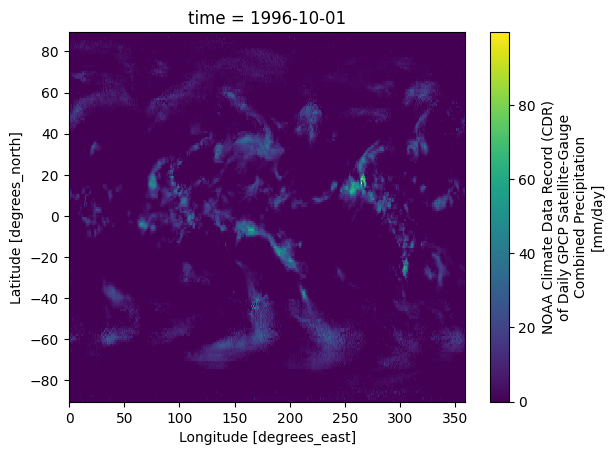

In [9]:
ds['precip'].isel(time=0).plot(x='longitude', y='latitude')

In [2]:
import napari

In [3]:
def get_scale_translate(dataset, array_name):
    """Get the translate/offset and scale parameters for an xarray dataset.

    This code assumes that the dataset is regularly spaced. You should
    interpolate your data if it is sampled at irregular spaces.

    Parameters
    ----------
    dataset : xr.Dataset
        The dataset containing the array to be displayed.
    array_name : str
        The name of the xarray DataArray within `dataset` to be displayed in
        napari.

    Returns
    -------
    param_dict : dict[str, list[float]]
        The scale and translate parameters computed from the xarray dimension
        indices.
    """
    array = getattr(dataset, array_name)
    if array is None:
        raise ValueError(f"{dataset} has no array with name {array_name}")
    dims = [getattr(dataset, dim) for dim in array.dims]
    translate = [float(d[0]) for d in dims]
    scale = [float(d[1] - d[0]) for d in dims]
    return {"scale": scale, "translate": translate}

In [4]:
precip = ds["precip"]
viewer, precip_layer = napari.imshow(
        precip,
        name=precip.attrs["standard_name"],
        **get_scale_translate(ds, 'precip'),
        colormap='viridis',
        )
viewer.dims.axis_labels = precip.dims

# latitude goes from -90 (south, down) to 90 (north, up),
# so we make sure that the camera vertical axis points up.
viewer.camera.orientation2d = ('up', 'right')

# fill the frame
viewer.reset_view(margin=0)